In [78]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr, chi2_contingency
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")
import joblib

In [79]:
# Load the datasets
bike_sales = pd.read_excel('Bike_Sales.xlsx')
bike_sales_uganda = pd.read_excel('Bike_sales_Uganda.xlsx')

In [80]:
bike_sales.head(2)

,Date,Day,Month,Year,Customer_Age,Age_Group,Customer_Gender,Country,State,Product_Category,Sub_Category,Product,Order_Quantity,Unit_Cost,Unit_Price,Profit,Cost,Revenue
0,2017-01-01,1,January,2017,17,Youth (<25),M,Canada,British Columbia,Bikes,Road Bikes,"Road-250 Red, 44",2,1519,2443,1848,3038,4886
1,2017-01-01,1,January,2017,23,Youth (<25),M,Australia,Victoria,Bikes,Mountain Bikes,"Mountain-200 Black, 46",2,1252,2295,2086,2504,4590


In [81]:
bike_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113036 entries, 0 to 113035
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Date              113036 non-null  datetime64[ns]
 1   Day               113036 non-null  int64         
 2   Month             113036 non-null  object        
 3   Year              113036 non-null  int64         
 4   Customer_Age      113036 non-null  int64         
 5   Age_Group         113036 non-null  object        
 6   Customer_Gender   113036 non-null  object        
 7   Country           113036 non-null  object        
 8   State             113036 non-null  object        
 9   Product_Category  113036 non-null  object        
 10  Sub_Category      113036 non-null  object        
 11  Product           113036 non-null  object        
 12  Order_Quantity    113036 non-null  int64         
 13  Unit_Cost         113036 non-null  int64         
 14  Unit

In [82]:
bike_sales.describe()

,Date,Day,Year,Customer_Age,Order_Quantity,Unit_Cost,Unit_Price,Profit,Cost,Revenue
count,113036,113036.000000,113036.000000,113036.000000,113036.000000,113036.000000,113036.000000,113036.000000,113036.000000,113036.000000
mean,2020-01-06 01:36:09.376127744,15.665753,2019.520153,35.919212,11.901660,267.296366,452.938427,372.681358,469.318695,842.000053
min,2017-01-01 00:00:00,1.000000,2017.000000,17.000000,1.000000,1.000000,2.000000,1.000000,1.000000,2.000000
25%,2019-01-09 00:00:00,8.000000,2019.000000,28.000000,2.000000,2.000000,5.000000,39.000000,28.000000,70.000000
50%,2019-10-16 00:00:00,16.000000,2019.500000,35.000000,10.000000,9.000000,24.000000,135.000000,108.000000,245.000000
75%,2021-01-28 00:00:00,23.000000,2021.000000,43.000000,20.000000,42.000000,70.000000,432.000000,432.000000,880.000000
max,2021-12-31 00:00:00,31.000000,2021.000000,87.000000,32.000000,2171.000000,3578.000000,26158.000000,42978.000000,69136.000000
std,NaN,8.781567,1.179704,11.021936,9.561857,549.835483,922.071219,595.080571,884.866118,1466.202934


In [83]:
bike_sales.shape

(113036, 18)

In [84]:
bike_sales.columns

Index(['Date', 'Day', 'Month', 'Year', 'Customer_Age', 'Age_Group',
       'Customer_Gender', 'Country', 'State', 'Product_Category',
       'Sub_Category', 'Product', 'Order_Quantity', 'Unit_Cost', 'Unit_Price',
       'Profit', 'Cost', 'Revenue'],
      dtype='object')

In [85]:
# Check for missing values
print("Missing values in each column of Bike_Sales:")
print(bike_sales.isnull().sum())

Missing values in each column of Bike_Sales:
Date                0
Day                 0
Month               0
Year                0
Customer_Age        0
Age_Group           0
Customer_Gender     0
Country             0
State               0
Product_Category    0
Sub_Category        0
Product             0
Order_Quantity      0
Unit_Cost           0
Unit_Price          0
Profit              0
Cost                0
Revenue             0
dtype: int64


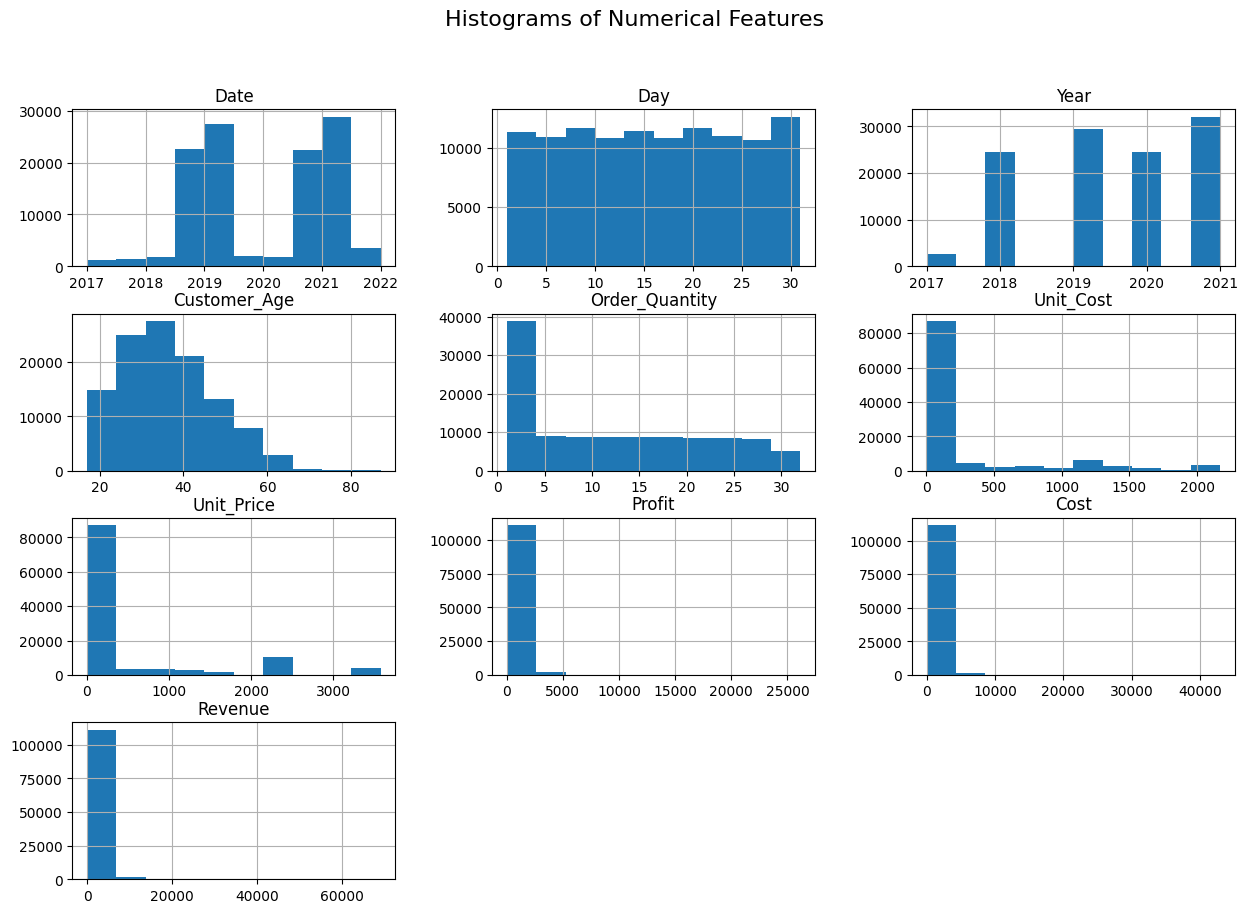

In [86]:
# Data Visualization
## Histograms
bike_sales.hist(figsize=(15, 10))
plt.suptitle('Histograms of Numerical Features', fontsize=16)
plt.show()

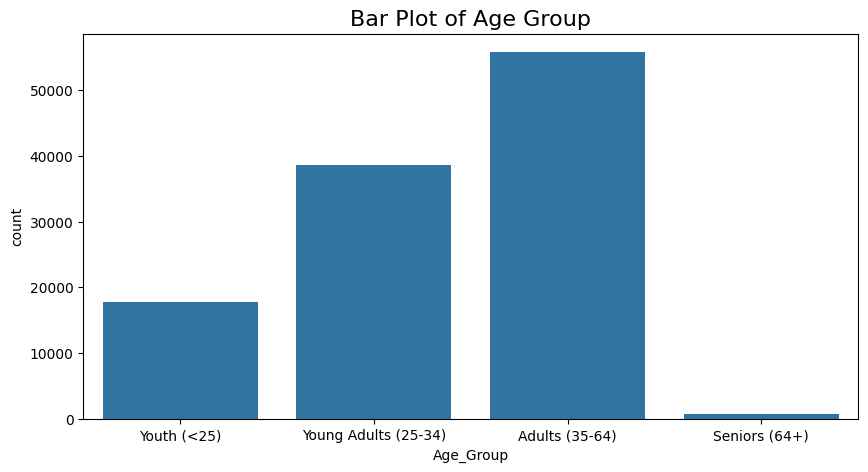

In [87]:
## Bar plots for categorical data
plt.figure(figsize=(10, 5))
sns.countplot(data=bike_sales, x='Age_Group')
plt.title('Bar Plot of Age Group', fontsize=16)
plt.show()

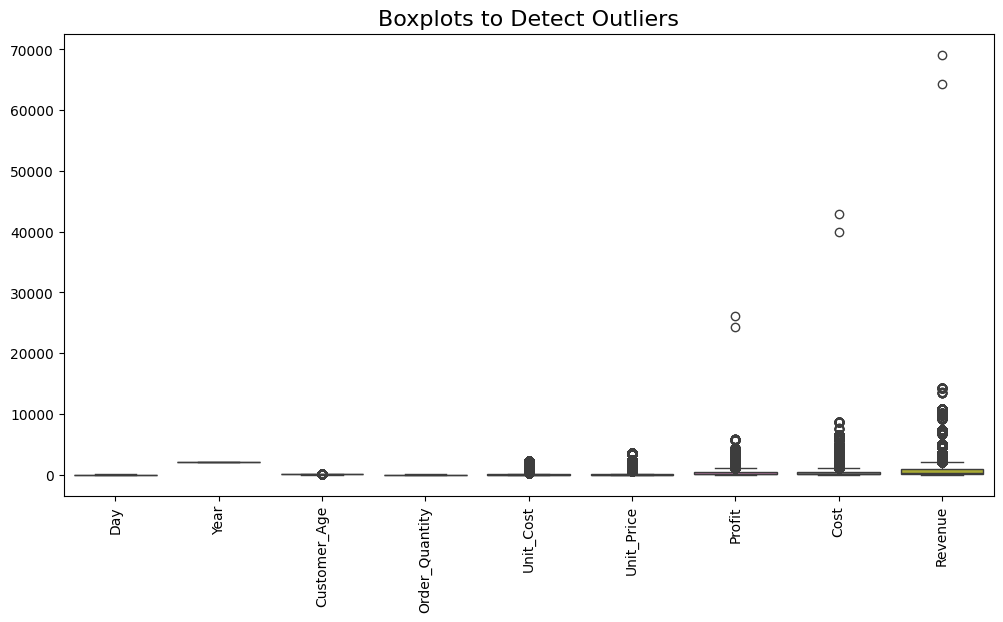

In [88]:
## Box plots
plt.figure(figsize=(12, 6))
sns.boxplot(data=bike_sales)
plt.xticks(rotation=90)
plt.title('Boxplots to Detect Outliers', fontsize=16)
plt.show()

In [89]:
def calculate_outlier_percentages(df, columns):
    """
    Calculate the percentage of outliers in each specified numeric column using the IQR method.

    Args:
        df (pd.DataFrame): The dataframe to process.
        columns (list): List of column names to check for outliers.

    Returns:
        dict: A dictionary with column names as keys and the percentage of outliers as values.
    """
    percentages = {}
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        percentage = (len(outliers) / len(df)) * 100
        percentages[column] = percentage
    return percentages

def print_outlier_percentages(df, columns):
    """
    Print the percentage of outliers for each specified numeric column and calculate the overall percentage of outliers.

    Args:
        df (pd.DataFrame): The dataframe to process.
        columns (list): List of column names to check for outliers.
    """
    outlier_percentages = calculate_outlier_percentages(df, columns)
    total_outliers = 0
    total_data_points = df.shape[0] * len(columns)
    
    for column, percentage in outlier_percentages.items():
        print(f"Column '{column}' has {percentage:.2f}% outliers")
        total_outliers += (percentage / 100) * df.shape[0]
    
    overall_percentage = (total_outliers / total_data_points) * 100
    print(f"\nOverall percentage of outliers in the dataset: {overall_percentage:.2f}%")

# Load the training dataset
numerical_vars = bike_sales.select_dtypes(include=['number']).columns.tolist()

# Print outlier percentages
print_outlier_percentages(bike_sales, numerical_vars)


Column 'Day' has 0.00% outliers
Column 'Year' has 0.00% outliers
Column 'Customer_Age' has 0.47% outliers
Column 'Order_Quantity' has 0.00% outliers
Column 'Unit_Cost' has 22.99% outliers
Column 'Unit_Price' has 22.99% outliers
Column 'Profit' has 11.45% outliers
Column 'Cost' has 16.08% outliers
Column 'Revenue' has 14.58% outliers

Overall percentage of outliers in the dataset: 9.84%


In [90]:
def calculate_upper_bound(data, column):
    """
    Calculate the upper bound for a column using the IQR method.

    Args:
        data (pd.DataFrame): The dataframe containing the data.
        column (str): The column name for which to calculate the upper bound.

    Returns:
        float: The calculated upper bound.
    """
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    return upper_bound

def replace_outliers_with_upper_bound(df, columns):
    """
    Replace outliers in the specified columns with the upper bound.

    Args:
        df (pd.DataFrame): The dataframe containing the data.
        columns (list): List of column names to check for outliers.

    Returns:
        pd.DataFrame: The dataframe with outliers replaced.
    """
    df_cleaned = df.copy()
    for column in columns:
        upper_bound = calculate_upper_bound(df, column)
        df_cleaned[column] = df_cleaned[column].apply(lambda x: min(x, upper_bound))
    return df_cleaned

def calculate_outlier_percentages(df, columns):
    """
    Calculate the percentage of outliers in each specified numeric column using the IQR method.

    Args:
        df (pd.DataFrame): The dataframe to process.
        columns (list): List of column names to check for outliers.

    Returns:
        dict: A dictionary with column names as keys and the percentage of outliers as values.
    """
    percentages = {}
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        percentage = (len(outliers) / len(df)) * 100
        percentages[column] = percentage
    return percentages

def print_outlier_percentages(df, columns):
    """
    Print the percentage of outliers for each specified numeric column and calculate the overall percentage of outliers.

    Args:
        df (pd.DataFrame): The dataframe to process.
        columns (list): List of column names to check for outliers.
    """
    outlier_percentages = calculate_outlier_percentages(df, columns)
    total_outliers = 0
    total_data_points = df.shape[0] * len(columns)
    
    for column, percentage in outlier_percentages.items():
        print(f"Column '{column}' has {percentage:.2f}% outliers")
        total_outliers += (percentage / 100) * df.shape[0]
    
    overall_percentage = (total_outliers / total_data_points) * 100
    print(f"\nOverall percentage of outliers in the dataset: {overall_percentage:.2f}%")


# Columns of interest
columns_with_outliers = ['Customer_Age', 'Unit_Cost', 'Unit_Price', 'Profit', 'Cost', 'Revenue']

# Replace outliers with the upper bound
bike_sales_data_cleaned = replace_outliers_with_upper_bound(bike_sales, columns_with_outliers)

# Calculate and print upper bounds for each column
upper_bounds = {column: calculate_upper_bound(bike_sales, column) for column in columns_with_outliers}

print("Upper bounds for the specified variables:")
for column, upper_bound in upper_bounds.items():
    print(f"{column}: {upper_bound}")

# Check the outlier percentages after the replacement of the upper bounds
print("\nOutlier percentages after replacement with upper bounds:")
print_outlier_percentages(bike_sales_data_cleaned, columns_with_outliers)


Upper bounds for the specified variables:
Customer_Age: 65.5
Unit_Cost: 102.0
Unit_Price: 167.5
Profit: 1021.5
Cost: 1038.0
Revenue: 2095.0

Outlier percentages after replacement with upper bounds:
Column 'Customer_Age' has 0.00% outliers
Column 'Unit_Cost' has 0.00% outliers
Column 'Unit_Price' has 0.00% outliers
Column 'Profit' has 0.00% outliers
Column 'Cost' has 0.00% outliers
Column 'Revenue' has 0.00% outliers

Overall percentage of outliers in the dataset: 0.00%


In [91]:
# Save the cleaned dataset as "Sentongo.xlsx"
output_filename = "Sentongo.xlsx"
bike_sales_data_cleaned.to_excel(output_filename, index=False)

print(f"Cleaned dataset saved as {output_filename}")

Cleaned dataset saved as Sentongo.xlsx


In [92]:
bike_sales_data_cleaned = pd.read_excel('Sentongo.xlsx')

In [93]:
bike_sales_data_cleaned.head(2)

,Date,Day,Month,Year,Customer_Age,Age_Group,Customer_Gender,Country,State,Product_Category,Sub_Category,Product,Order_Quantity,Unit_Cost,Unit_Price,Profit,Cost,Revenue
0,2017-01-01,1,January,2017,17.0,Youth (<25),M,Canada,British Columbia,Bikes,Road Bikes,"Road-250 Red, 44",2,102,167.5,1021.5,1038,2095
1,2017-01-01,1,January,2017,23.0,Youth (<25),M,Australia,Victoria,Bikes,Mountain Bikes,"Mountain-200 Black, 46",2,102,167.5,1021.5,1038,2095


In [94]:
def list_columns_by_type(df):
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
    continuous_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    
    return categorical_columns, continuous_columns

# Get categorical and continuous columns
categorical_columns, continuous_columns = list_columns_by_type(bike_sales_data_cleaned)

print("Categorical Columns:")
print(categorical_columns)

print("\nContinuous Columns:")
print(continuous_columns)

Categorical Columns:
['Month', 'Age_Group', 'Customer_Gender', 'Country', 'State', 'Product_Category', 'Sub_Category', 'Product']

Continuous Columns:
['Day', 'Year', 'Customer_Age', 'Order_Quantity', 'Unit_Cost', 'Unit_Price', 'Profit', 'Cost', 'Revenue']


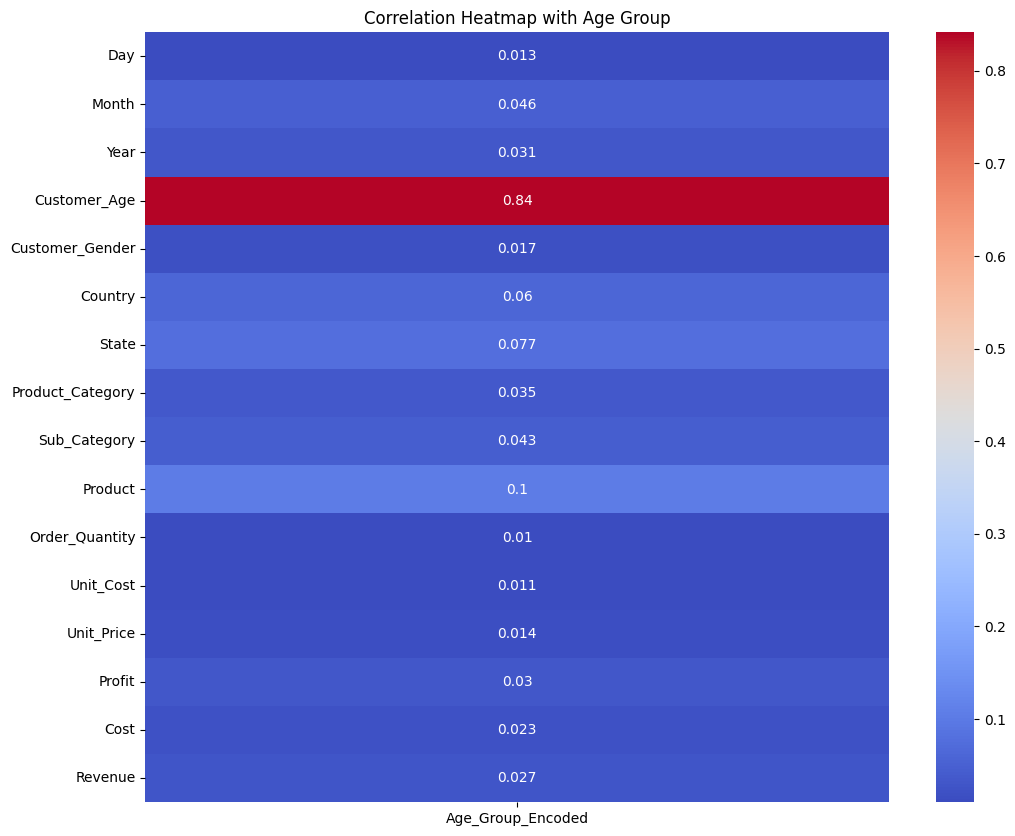

In [95]:
# Encode the Age_Group column
label_encoder = LabelEncoder()
bike_sales_data_cleaned['Age_Group_Encoded'] = label_encoder.fit_transform(bike_sales_data_cleaned['Age_Group'])

# Initialize a correlation matrix
corr_matrix = pd.DataFrame(index=bike_sales_data_cleaned.columns, columns=['Age_Group_Encoded'])

# Calculate correlations for categorical vs. categorical
categorical_columns = ['Month', 'Customer_Gender', 'Country', 'State', 'Product_Category', 'Sub_Category', 'Product']
for col in categorical_columns:
    cross_tab = pd.crosstab(bike_sales_data_cleaned[col], bike_sales_data_cleaned['Age_Group_Encoded'])
    chi2, p, dof, ex = chi2_contingency(cross_tab)
    cramer_v = np.sqrt(chi2 / (bike_sales_data_cleaned.shape[0] * min(cross_tab.shape) - 1))
    corr_matrix.loc[col, 'Age_Group_Encoded'] = cramer_v

# Calculate correlations for continuous vs. categorical
continuous_columns = ['Day', 'Year', 'Customer_Age', 'Order_Quantity', 'Unit_Cost', 'Unit_Price', 'Profit', 'Cost', 'Revenue']
for col in continuous_columns:
    corr, p_value = pointbiserialr(bike_sales_data_cleaned['Age_Group_Encoded'], bike_sales_data_cleaned[col])
    corr_matrix.loc[col, 'Age_Group_Encoded'] = np.abs(corr)

# Drop columns not needed
corr_matrix = corr_matrix.dropna()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix.astype(float), annot=True, cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap with Age Group')
plt.show()

In [96]:
# Generate list of features with highest correlations
high_corr_features = corr_matrix['Age_Group_Encoded'].sort_values(ascending=False)

# Print the features with their correlation values
print("Below are the features with the highest correlation with Age Group:")
for feature, corr_value in high_corr_features.items():
    print(f"{feature}: {corr_value:.4f}")

Below are the features with the highest correlation with Age Group:
Customer_Age: 0.8416
Product: 0.1021
State: 0.0773
Country: 0.0602
Month: 0.0465
Sub_Category: 0.0429
Product_Category: 0.0353
Year: 0.0305
Profit: 0.0304
Revenue: 0.0273
Cost: 0.0229
Customer_Gender: 0.0172
Unit_Price: 0.0145
Day: 0.0132
Unit_Cost: 0.0108
Order_Quantity: 0.0102


High Correlation of Customer_Age:

It makes sense that Customer_Age has a high correlation with Age Group because the Age Group is derived from Customer_Age. This feature is likely to be directly predictive of the target variable.

Low Correlation of Other Features:

The other features have very low correlation values with the Age Group. This suggests that these features do not have a strong linear relationship with the target variable.

PERSONAL ANALYSIS

Even though the other features have low correlation values, some of them might still be useful based on domain knowledge. For instance, Product, Country, and State might still contribute useful information in a more complex relationship that isn't captured by simple correlation measures.

In [97]:
# Encode categorical features
categorical_columns = ['Month', 'Customer_Gender', 'Country', 'State', 'Product_Category', 'Sub_Category', 'Product']
df_encoded = pd.get_dummies(bike_sales_data_cleaned, columns=categorical_columns)

In [98]:
# Split data into features and target
X = df_encoded.drop(columns=['Age_Group', 'Age_Group_Encoded', 'Date'])
y = bike_sales_data_cleaned['Age_Group_Encoded']

In [99]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [100]:
# Train a Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Top features based on Random Forest importance:
                   importance
Customer_Age         0.706140
Day                  0.038363
Profit               0.020553
Revenue              0.020031
Cost                 0.019759
Order_Quantity       0.019150
Year                 0.010783
Customer_Gender_M    0.007133
Customer_Gender_F    0.007106
Unit_Price           0.005339


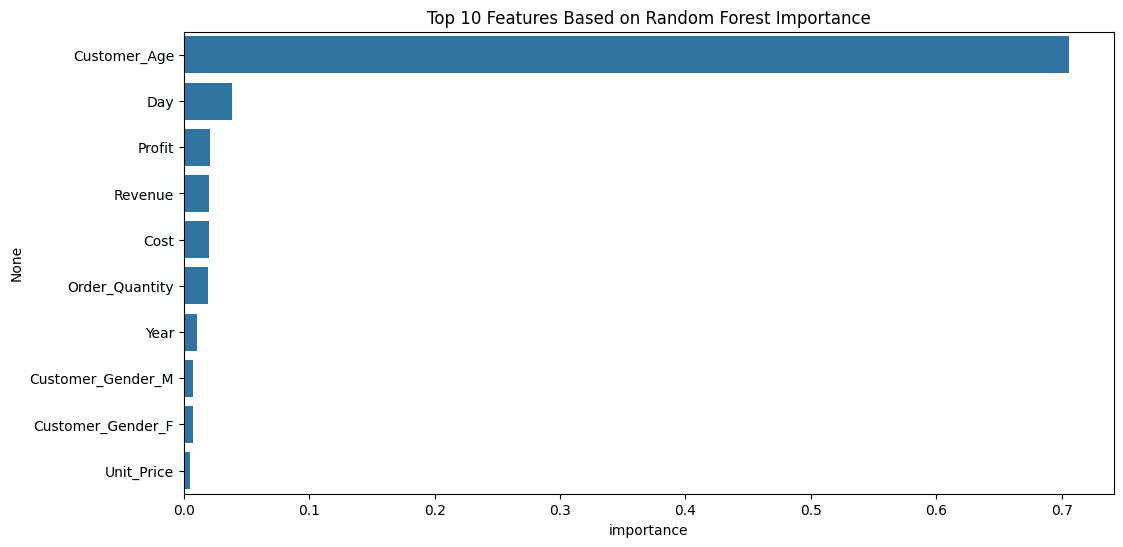

In [101]:
# Get feature importances
feature_importances = pd.DataFrame(rf.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)

# Print the top features
print("Top features based on Random Forest importance:")
print(feature_importances.head(10))

# Plot feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importances.head(10).importance, y=feature_importances.head(10).index)
plt.title('Top 10 Features Based on Random Forest Importance')
plt.show()

Based on the feature importances from the Random Forest model, let's select the top features and retrain the model using these features. Then, we will save the trained model as age_predictor.joblib

In [110]:
# Select the top features
top_features = ['Customer_Age', 'Day', 'Profit', 'Revenue', 'Cost', 'Order_Quantity','Year','Unit_Price']

In [111]:
# Split data into features and target
X = bike_sales_data_cleaned[top_features]
y = bike_sales_data_cleaned['Age_Group_Encoded']

In [112]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [113]:
# Train a Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [115]:
# Save the model
joblib_file = "age_predictor.joblib"
joblib.dump(rf, joblib_file)
print(f"Model saved as {joblib_file}")

Model saved as age_predictor.joblib


In [116]:
# Evaluate the model
from sklearn.metrics import classification_report, accuracy_score

# Make predictions
y_pred = rf.predict(X_test)

# Print evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11147
           1       1.00      1.00      1.00       168
           2       1.00      1.00      1.00      7703
           3       1.00      1.00      1.00      3590

    accuracy                           1.00     22608
   macro avg       1.00      1.00      1.00     22608
weighted avg       1.00      1.00      1.00     22608

Accuracy Score:
1.0
